In [1]:
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler

def load_data_lab2(path):
    with open(path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        feature_count = int(lines[0])
        train_n = int(lines[1])
        lines = lines[2:]

        train_X = []
        train_Y = []
        for i in range(train_n):
            row = list(map(float, lines[i].split()))
            assert len(row) == feature_count + 1
            train_X.append(row[:-1] + [1.0])
            train_Y.append(row[-1])

        lines = lines[train_n:]

        test_n = int(lines[0])
        lines = lines[1:]
        test_X = []
        test_Y = []
        for i in range(test_n):
            row = list(map(float, lines[i].split()))
            assert len(row) == feature_count + 1
            test_X.append(row[:-1] + [1.0])
            test_Y.append(row[-1])


        scalerX = MinMaxScaler()
        scalerX.fit(train_X)

        scalerY = MinMaxScaler()
        scalerY.fit(np.array([train_Y]).transpose())

        return np.array(scalerX.transform(train_X)), scalerY.transform(np.array([train_Y]).transpose())[:, 0], np.array(scalerX.transform(test_X)), scalerY.transform(np.array([test_Y]).transpose())[:, 0]

In [3]:
train_X, train_Y, test_X, test_Y = load_data_lab2("data/1.txt")
X_train, Y_train, X_test, Y_test = train_X, train_Y, test_X, test_Y

In [4]:
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(1164, 429) (1164,) (256, 429) (256,)


# Настройка гиперпараметров

## МНК

In [5]:
import optuna, cfml.linear, math

In [6]:
def apply(model, X):
    Y = np.zeros((X.shape[0]))
    for i in range(X.shape[0]):
        Y[i] = model(X[i])
    return Y

def mse(Y_real, Y_pred):
    return ((Y_real - Y_pred) ** 2).mean()

In [7]:
def mse_least_squares_target(trial):
    ln_tau = trial.suggest_float("ln_tau", -9, 0)
    model = cfml.linear.LeastSquares(X_train, Y_train, math.exp(ln_tau))
    return mse(Y_test, apply(model, X_test))

In [8]:
study1 = optuna.create_study()
study1.optimize(mse_least_squares_target, n_trials=100)

[I 2022-04-12 23:40:36,848] A new study created in memory with name: no-name-20c9d75c-57fc-4b01-a897-f4efefa91fe4
[I 2022-04-12 23:40:36,890] Trial 0 finished with value: 4.1949012154644035e-10 and parameters: {'ln_tau': -1.9160149103839572}. Best is trial 0 with value: 4.1949012154644035e-10.
[I 2022-04-12 23:40:36,921] Trial 1 finished with value: 1.3445426128937976e-10 and parameters: {'ln_tau': -5.657962063262277}. Best is trial 1 with value: 1.3445426128937976e-10.
[I 2022-04-12 23:40:36,955] Trial 2 finished with value: 6.010407404520794e-10 and parameters: {'ln_tau': -1.4101204458328267}. Best is trial 1 with value: 1.3445426128937976e-10.
[I 2022-04-12 23:40:36,988] Trial 3 finished with value: 1.8261756529162562e-10 and parameters: {'ln_tau': -4.628483188138054}. Best is trial 1 with value: 1.3445426128937976e-10.
[I 2022-04-12 23:40:37,020] Trial 4 finished with value: 1.1633857511779285e-09 and parameters: {'ln_tau': -0.8666617589966847}. Best is trial 1 with value: 1.344542

In [9]:
study1.best_params

{'ln_tau': -8.666814802845284}

In [10]:
study1.best_trial

FrozenTrial(number=48, values=[9.318910214197732e-11], datetime_start=datetime.datetime(2022, 4, 12, 23, 40, 38, 825137), datetime_complete=datetime.datetime(2022, 4, 12, 23, 40, 38, 863114), params={'ln_tau': -8.666814802845284}, distributions={'ln_tau': UniformDistribution(high=0.0, low=-9.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=48, state=TrialState.COMPLETE, value=None)

## StochasticGradientMSE

In [11]:
def mse_sg_target(trial):
    ln_tau = trial.suggest_float("ln_tau", -9, 0)
    ln_h = trial.suggest_float("ln_h", -9, 0)
    ln_lambd = trial.suggest_float("ln_lambd", -9, 0)
    model = cfml.linear.StochasticGradientMSE(X_train, Y_train, math.exp(ln_h), math.exp(ln_lambd), math.exp(ln_tau), seed=0)
    _res = mse(Y_test, apply(model, X_test))
    # print(_res, ln_tau, ln_h, ln_lambd)
    return _res

In [12]:
study2 = optuna.create_study()
study2.optimize(mse_sg_target, n_trials=100)

[I 2022-04-12 23:40:41,870] A new study created in memory with name: no-name-9a8633bd-4e8d-4c6a-8feb-7941aab6abc8
[I 2022-04-12 23:40:41,879] Trial 0 finished with value: 0.2590905003609256 and parameters: {'ln_tau': -2.198979309434147, 'ln_h': -6.562036513569687, 'ln_lambd': -4.885498400423075}. Best is trial 0 with value: 0.2590905003609256.
[I 2022-04-12 23:40:41,885] Trial 1 finished with value: 0.25908706551123006 and parameters: {'ln_tau': -6.287437112166655, 'ln_h': -6.668618782981342, 'ln_lambd': -7.780014629331437}. Best is trial 1 with value: 0.25908706551123006.
C:\Programing\sem6\ml\lab2\cfml\linear.py:111: RuntimeWarning: overflow encountered in double_scalars
  return (self._call(x) - y) ** 2
C:\Programing\sem6\ml\lab2\cfml\linear.py:114: RuntimeWarning: overflow encountered in multiply
  return 2 * (self._call(x) - y) * self._theta
[W 2022-04-12 23:40:41,898] Trial 2 failed, because the objective function returned nan.
[I 2022-04-12 23:40:41,933] Trial 3 finished with va

In [13]:
study2.best_params

{'ln_tau': -3.6481681042127505,
 'ln_h': -1.1059587448299322,
 'ln_lambd': -5.363347342955206}

## StochasticGradientSMAPE

In [14]:
def smape(Y_real, Y_pred):
    return (np.abs(Y_real - Y_pred) / (np.abs(Y_real) + np.abs(Y_pred))).mean()

def smape_sg_target(trial):
    ln_tau = trial.suggest_float("ln_tau", -9, 0)
    ln_h = trial.suggest_float("ln_h", -9, 0)
    ln_lambd = trial.suggest_float("ln_lambd", -9, 0)
    model = cfml.linear.StochasticGradientSMAPE(X_train, Y_train, math.exp(ln_h), math.exp(ln_lambd), math.exp(ln_tau), seed=0)
    _res = smape(Y_test, apply(model, X_test))
    # print(_res, ln_tau, ln_h, ln_lambd)
    return _res

In [15]:
study3 = optuna.create_study()
study3.optimize(smape_sg_target, n_trials=100)

[I 2022-04-12 23:40:44,344] A new study created in memory with name: no-name-d217e2ff-3014-4cfe-9c37-d9885838e6a5
[I 2022-04-12 23:40:48,758] Trial 0 finished with value: 0.14954526116874134 and parameters: {'ln_tau': -2.5588714845752136, 'ln_h': -6.097140152427974, 'ln_lambd': -6.7148187496451115}. Best is trial 0 with value: 0.14954526116874134.
[I 2022-04-12 23:40:49,976] Trial 1 finished with value: 0.03905425476917564 and parameters: {'ln_tau': -8.555425719836704, 'ln_h': -6.992729162959152, 'ln_lambd': -4.3258999488239205}. Best is trial 1 with value: 0.03905425476917564.
[I 2022-04-12 23:40:51,892] Trial 2 finished with value: 0.02378433301351565 and parameters: {'ln_tau': -4.500397802277185, 'ln_h': -8.900868408815333, 'ln_lambd': -7.9694177863306015}. Best is trial 2 with value: 0.02378433301351565.
[I 2022-04-12 23:40:53,633] Trial 3 finished with value: 0.22651615526821475 and parameters: {'ln_tau': -8.03364094822101, 'ln_h': -7.457091587538189, 'ln_lambd': -3.13196534456216

In [16]:
study3.best_params

{'ln_tau': -0.5445421848946058,
 'ln_h': -8.693158530475385,
 'ln_lambd': -7.543324599178741}

# Тестирование

## График зависимости ошибки SMAPE и MSE на тестовом множестве от параметра регуляризации для метода наименьших квадратов.

In [17]:
def mse_ls_test(ln_tau):
    model = cfml.linear.LeastSquares(X_train, Y_train, math.exp(ln_tau))
    return mse(Y_test, apply(model, X_test))

def smape_ls_test(ln_tau):
    model = cfml.linear.LeastSquares(X_train, Y_train, math.exp(ln_tau))
    return smape(Y_test, apply(model, X_test))

In [18]:
ln_tau_list = np.linspace(-9, 0, num=40)
mse_res = np.vectorize(mse_ls_test)(ln_tau_list)
smape_res = np.vectorize(smape_ls_test)(ln_tau_list)

In [19]:
import matplotlib.pyplot as plt

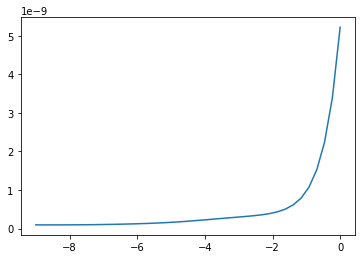

In [20]:
plt.plot(ln_tau_list, mse_res)

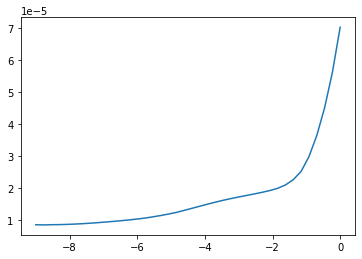

In [21]:
plt.plot(ln_tau_list, smape_res)

## График зависимости экспоненциального скользящего среднего эмпирического риска на тренировочном множестве для градиентных спусков.

In [22]:
def params_exp(params):
    res = dict()
    for key in params:
        if key.startswith("ln_"):
            res[key[3:]] = math.exp(params[key])
        else:
            res[key] = params[key]
    return res

In [23]:
best_smape_model = cfml.linear.StochasticGradientSMAPE(X_train, Y_train, seed=0, **params_exp(study3.best_params))
best_mse_model = cfml.linear.StochasticGradientMSE(X_train, Y_train, seed=0, **params_exp(study2.best_params))

apply(best_smape_model, X_test)
apply(best_mse_model, X_test)

print(best_smape_model.metric.shape, best_mse_model.metric.shape)

(2001,) (1319,)


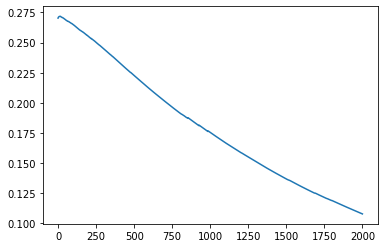

In [24]:
plt.plot(list(range(best_smape_model.metric.shape[0])), best_smape_model.metric)

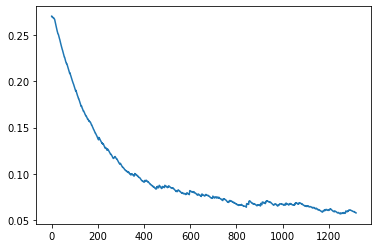

In [25]:
plt.plot(list(range(best_mse_model.metric.shape[0])), best_mse_model.metric)

## NRMSE и SMAPE

In [28]:
best_ls_model = model = cfml.linear.LeastSquares(X_train, Y_train, **params_exp(study1.best_params))

In [29]:
Y_pred_smape = apply(best_smape_model, X_test)
Y_pred_mse = apply(best_mse_model, X_test)
Y_pred_ls = apply(best_ls_model, X_test)

In [33]:
def nrmse(Y_real, Y_pred):
    return math.sqrt(mse(Y_real, Y_pred)) / (Y_real.max() - Y_real.min())

In [34]:
print("LeastSquares:            NRMSE:", nrmse(Y_test, Y_pred_ls), "\t\tSMAPE:", smape(Y_test, Y_pred_ls))
print("StochasticGradientMSE:   NRMSE:", nrmse(Y_test, Y_pred_mse), "\t\tSMAPE:", smape(Y_test, Y_pred_mse))
print("StochasticGradientSMAPE: NRMSE:", nrmse(Y_test, Y_pred_smape), "\t\tSMAPE:", smape(Y_test, Y_pred_smape))

LeastSquares:            NRMSE: 1.2416986178029347e-05 		SMAPE: 8.445799987184066e-06
StochasticGradientMSE:   NRMSE: 0.27761835058257206 		SMAPE: 0.17817499282868834
StochasticGradientSMAPE: NRMSE: 0.0019334412886812713 		SMAPE: 0.0014752487125979136
